#### Problem Statement

You are provided with historical sales data for 45 stores of a Retail chain located in different
regions. Each store contains a number of departments, and you are tasked with predicting the
department-wide sales for each store.


#### The Sales Forecasting Problem

Sales forecasting is all about using historical data to inform decision making.


On its core, this is a [time series](https://en.wikipedia.org/wiki/Time_series#:~:text=A%20time%20series%20is%20a,sequence%20of%20discrete%2Dtime%20data.) problem: given some data in time, we want to predict the dynamics of that same data in the future. To do this, we require some trainable model of these dynamics.


##### Types of Forecasting Models

According to this [article](https://hbr.org/1971/07/how-to-choose-the-right-forecasting-technique) featured in the harvard business review, there are three types of Forecasting techniques:



- __Qualitative techniques__: usually involve expert opinion or information about special events.


- __Time series analysis and projection__: involve historical data,finding structure in the dynamics of the data like cyclical patterns, trends and growth rates.


    
- __Causal models__: these models involve the relevant causal relationships that may include pipeline considerations like inventories or market survey information. They can incorporate the results of a time series analysis.

I used the retail data analytics to test a simple auto regressive (AR) model to forecast the sales volume using sales only and sales + external information. While the data might be used to draw many insights on this retail business, here I focus only on implementing the AR model to forecast the sales volume.We will focus on the time series analysis approach which has been the driving force behind traditional forecasting methods and, it can give a comprehensive layout of the forecasting landscape.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
features=pd.read_csv("features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [3]:
stores=pd.read_csv("stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
train=pd.read_csv("train.csv")
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
test=pd.read_csv("test.csv")
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [6]:
df=features.merge(stores,on='Store',how='outer')
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [7]:
df=df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1)
df.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,211.350143,8.106,False,A,151315


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   CPI           7605 non-null   float64
 5   Unemployment  7605 non-null   float64
 6   IsHoliday     8190 non-null   bool   
 7   Type          8190 non-null   object 
 8   Size          8190 non-null   int64  
dtypes: bool(1), float64(4), int64(2), object(2)
memory usage: 583.9+ KB


In [9]:
from sklearn.preprocessing import LabelEncoder
l=LabelEncoder()
df['IsHoliday']=l.fit_transform(df['IsHoliday'])
df['Type']=l.fit_transform(df['Type'])

In [10]:
df.shape

(8190, 9)

In [11]:
df1=train.merge(df,on=['Date','Store'])
df1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,0,0,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,0,0,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,0,0,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,0,0,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,0,0,151315


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139088 entries, 0 to 139087
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         139088 non-null  int64  
 1   Dept          139088 non-null  int64  
 2   Date          139088 non-null  object 
 3   Weekly_Sales  139088 non-null  float64
 4   IsHoliday_x   139088 non-null  bool   
 5   Temperature   139088 non-null  float64
 6   Fuel_Price    139088 non-null  float64
 7   CPI           139088 non-null  float64
 8   Unemployment  139088 non-null  float64
 9   IsHoliday_y   139088 non-null  int64  
 10  Type          139088 non-null  int64  
 11  Size          139088 non-null  int64  
dtypes: bool(1), float64(5), int64(5), object(1)
memory usage: 12.9+ MB


In [13]:
df1=df1.drop('IsHoliday_x',axis=1)

In [14]:
df1['Date'].nunique()

143

In [15]:
sales_weekly = df1.groupby(['Date', 'IsHoliday_y'], as_index = False).agg({'Weekly_Sales':"sum"})
sales_weekly

,Date,IsHoliday_y,Weekly_Sales
0,2010-02-05,0,19910348.85
1,2010-02-12,1,19092737.75
2,2010-02-19,0,19057399.45
3,2010-02-26,0,17517283.12
4,2010-03-05,0,18466385.02
...,...,...,...
138,2012-09-28,0,16529236.08
139,2012-10-05,0,18235643.78
140,2012-10-12,0,17458561.02
141,2012-10-19,0,17201215.17


In [16]:
sales_weekly['IsHoliday_y'].value_counts()

0    133
1     10
Name: IsHoliday_y, dtype: int64

In [17]:
df1['Weekly_Sales'].sum()

2613527844.5

In [18]:
#temperature unit conversion
df1['Temperature'] = (df1['Temperature']- 32) * 5./9.

#factorize (Yes/No to 1/0 conversion)
holidays_factor, types =df1['IsHoliday_y'].factorize()
df1['IsHoliday_y'] = holidays_factor

df1['Date'] = df1['Date'].apply(pd.to_datetime)

df1.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,5.727778,2.572,211.096358,8.106,0,0,151315
1,1,2,2010-02-05,50605.27,5.727778,2.572,211.096358,8.106,0,0,151315
2,1,3,2010-02-05,13740.12,5.727778,2.572,211.096358,8.106,0,0,151315
3,1,4,2010-02-05,39954.04,5.727778,2.572,211.096358,8.106,0,0,151315
4,1,5,2010-02-05,32229.38,5.727778,2.572,211.096358,8.106,0,0,151315


In [19]:
df1['Y'] = df1['Date'].dt.year
df1['M'] = df1['Date'].dt.month
df1['D'] = df1['Date'].dt.dayofyear
df1['W'] = df1['Date'].dt.weekofyear

In [20]:
df1.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size,Y,M,D,W
0,1,1,2010-02-05,24924.50,5.727778,2.572,211.096358,8.106,0,0,151315,2010,2,36,5
1,1,2,2010-02-05,50605.27,5.727778,2.572,211.096358,8.106,0,0,151315,2010,2,36,5
2,1,3,2010-02-05,13740.12,5.727778,2.572,211.096358,8.106,0,0,151315,2010,2,36,5
3,1,4,2010-02-05,39954.04,5.727778,2.572,211.096358,8.106,0,0,151315,2010,2,36,5
4,1,5,2010-02-05,32229.38,5.727778,2.572,211.096358,8.106,0,0,151315,2010,2,36,5


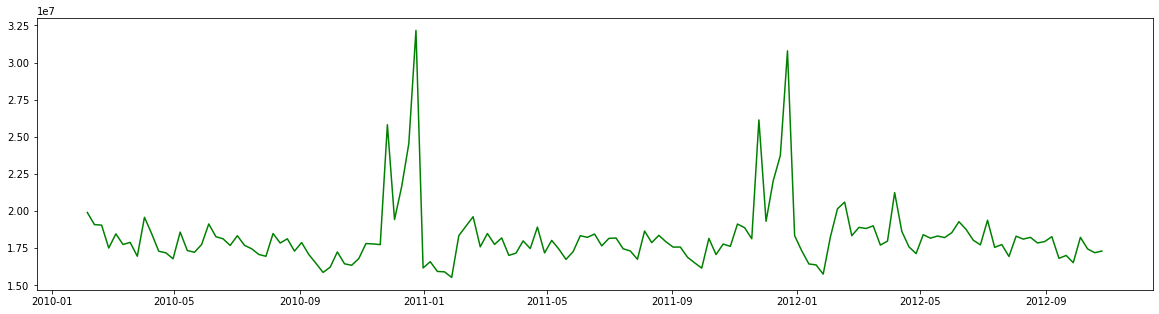

In [21]:
#### Sales analysis by dates, different types of stores and conditions
df_average_sales_weekly = df1.groupby('Date', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})

df_average_sales_sorted = df_average_sales_weekly.sort_values('Weekly_Sales', ascending = False)

plt.figure(figsize=(20,5))

plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales, color = 'g')

plt.show()

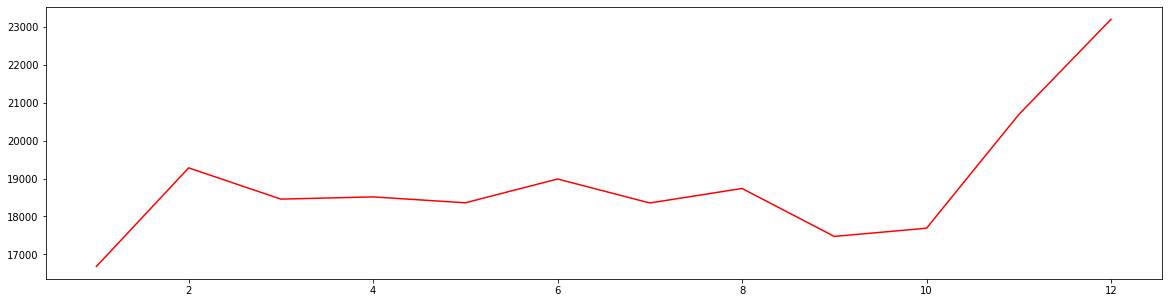

In [22]:
### weekly sales mean by months
df_average_sales_monthly = df1.groupby('M', as_index=False)\
    .agg({'Weekly_Sales': 'mean'})
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_monthly.M, df_average_sales_monthly.Weekly_Sales, color = 'r')
plt.show()

In [23]:
# Most profitable weeks
df_average_sales_sorted.head()

,Date,Weekly_Sales
46,2010-12-24,32171438.44
98,2011-12-23,30789969.50
94,2011-11-25,26139195.13
42,2010-11-26,25815810.96
45,2010-12-17,24545636.49


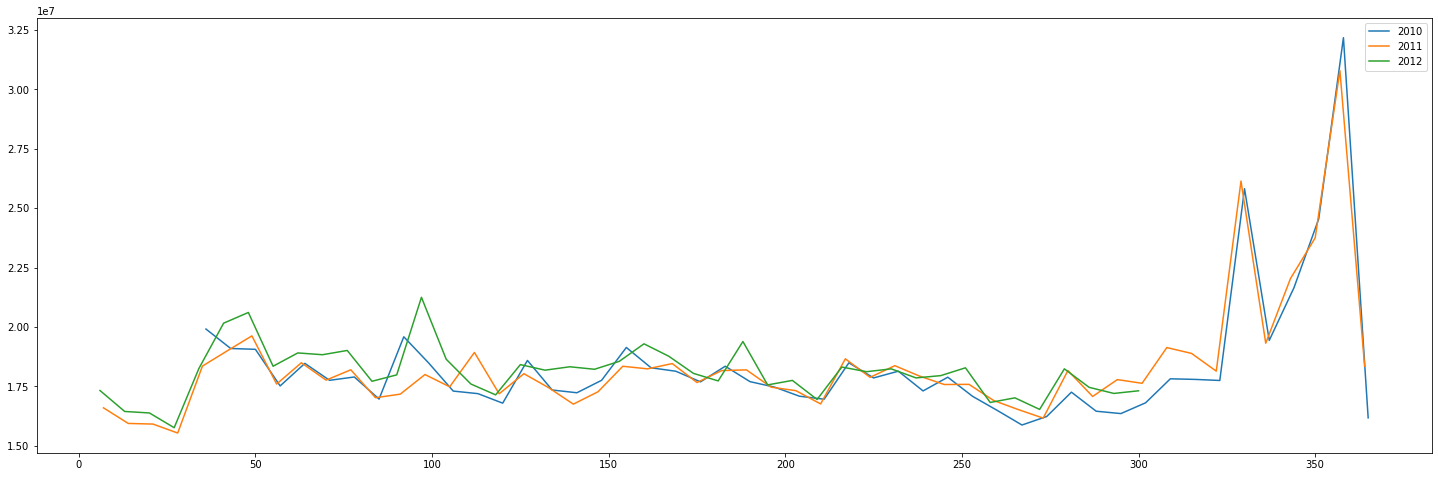

In [24]:
# Compare weekly sales by years
df_year10 = df1.query('Y == 2010').groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})
df_year11 = df1.query('Y == 2011').groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})
df_year12 = df1.query('Y == 2012').groupby('D', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(df_year10.D, df_year10.Weekly_Sales, label = "2010")
ax.plot(df_year11.D, df_year11.Weekly_Sales, label = "2011")
ax.plot(df_year12.D, df_year12.Weekly_Sales, label = "2012")
ax.legend()
plt.show()

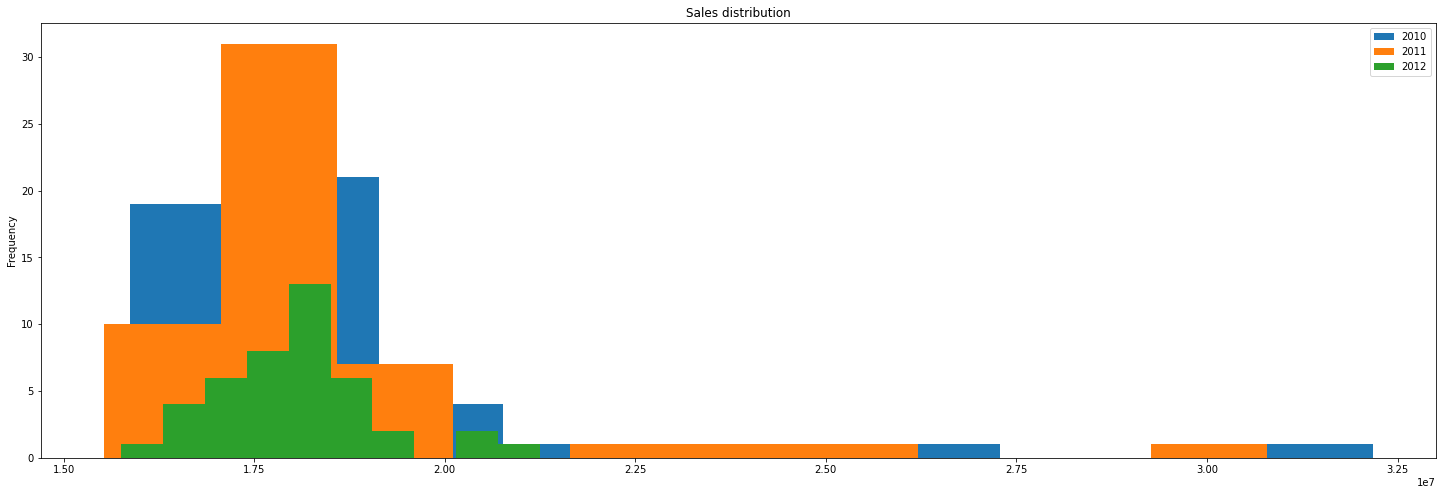

In [25]:
# Sales sums distribution

fig, ax = plt.subplots(figsize=(25,8))

df_year10['Weekly_Sales'].plot(kind='hist', title='Sales distribution', label = "2010");
df_year11['Weekly_Sales'].plot(kind='hist', label = "2011");
df_year12['Weekly_Sales'].plot(kind='hist', label = "2012");

ax.legend()
plt.show()

2012 sales do not have significant positive emissions like in 2010 and 2011 because of lack of data on 2012 december holidays weeks

In [26]:
# Rolling mean (window = 4)

df_average_sales_weekly['rol_month'] = df_average_sales_weekly['Weekly_Sales'].rolling(4).mean()

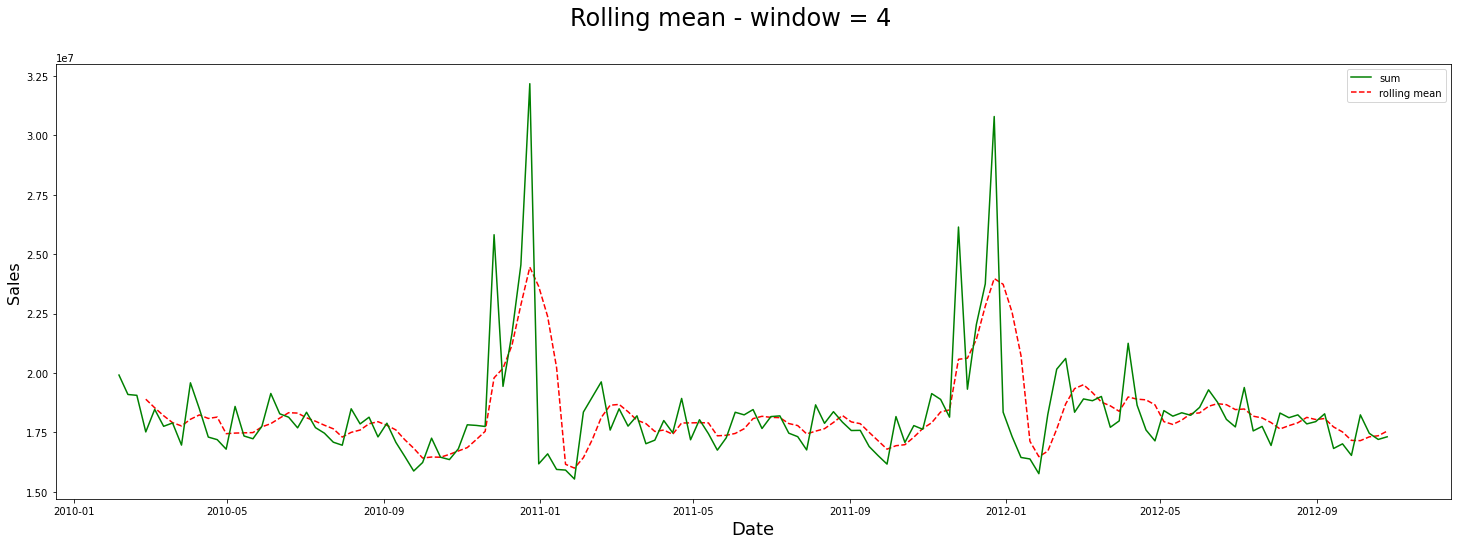

In [27]:
fig = plt.figure(figsize=(25,8))
line1, = plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.rol_month, '--', color='red')
line2, = plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales,  color='green')

fig.suptitle('Rolling mean - window = 4', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.legend((line2, line1), ['sum', 'rolling mean'])
plt.show()

The most profitable weeks and months coincide with the holidays of Christmas and Thanksgiving

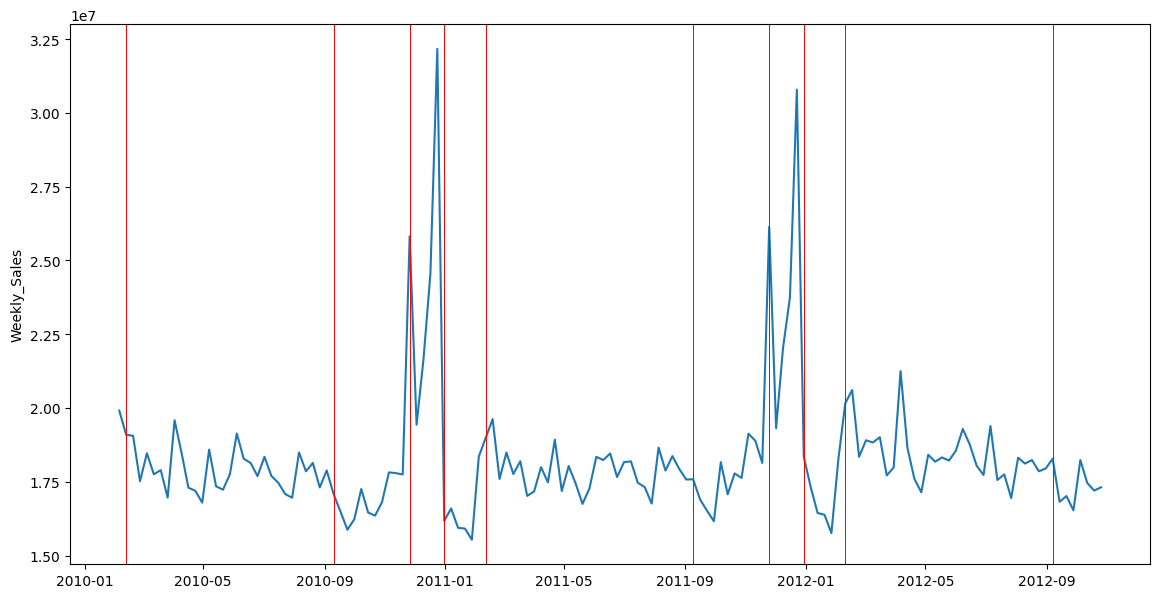

In [28]:
# holiday weeks are marked with red lines
df2=df1.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()

f_1 = plt.figure(figsize=(12,6), dpi=100)
ax_1 = f_1.add_axes([0.0, 0.0, 0.9, 0.9])
ax_1.set_ylabel('Weekly_Sales')
ax_1.plot(df2['Date'], df2['Weekly_Sales'])

for x in df1[df1['IsHoliday_y']==1]['Date']:
    ax_1.axvline(x=x, color='red', linewidth=0.5)

##### Sales analysis by store types

In [29]:
df_type = df1.groupby('Type', as_index=False).agg(Mean=('Weekly_Sales', 'mean'), Sum=('Weekly_Sales', 'sum'))
df_type

,Type,Mean,Sum
0,0,23583.144026,1.920517e+09
1,1,12020.587795,6.930109e+08


Text(0.5, 1.0, 'Mean weekly sales by years')

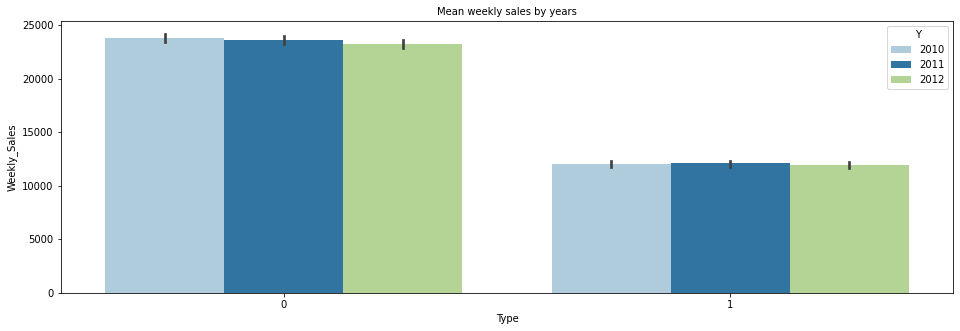

In [30]:
plt.figure(figsize = (16,5))
ax = sns.barplot(x="Type", y="Weekly_Sales", hue="Y", data=df1, palette= "Paired")
ax.set_title('Mean weekly sales by years',fontsize=10)

In [31]:
df_group_type = df1.groupby('Type', as_index = False)\
    .agg({'Weekly_Sales':'mean'})\
    .sort_values('Weekly_Sales', ascending = False)
df_group_type

,Type,Weekly_Sales
0,0,23583.144026
1,1,12020.587795


##### Top-5 stores by sales

In [32]:
df_group_store = df1.groupby('Store', as_index = False)\
    .agg({'Weekly_Sales':'sum'})\
    .sort_values('Weekly_Sales', ascending = False)
df_group_store.head()

,Store,Weekly_Sales
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08
1,2,2.753824e+08
9,10,2.716177e+08


##### Unemployment analysis

In [33]:
df_group_unemployment = df1.groupby('Y', as_index = False)\
    .agg({'Unemployment':'mean'})\
    .sort_values('Unemployment', ascending = False)
df_group_unemployment

,Y,Unemployment
0,2010,8.185414
1,2011,7.733007
2,2012,6.811626


##### The consumer price index

In [34]:
df_group_cpi = df1.groupby('Y', as_index = False)\
    .agg({'CPI':'mean'})\
    .sort_values('CPI', ascending = False)
df_group_cpi

,Y,CPI
2,2012,191.743620
1,2011,187.163382
0,2010,183.176545


##### Fuel Price tendency

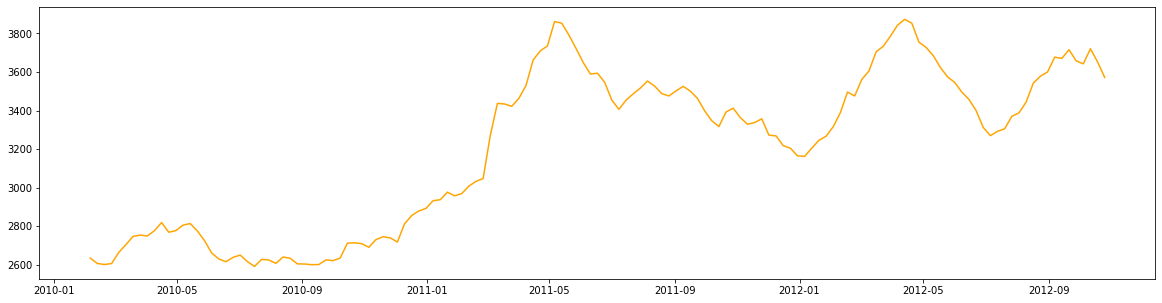

In [35]:
df_average_sales_weekly2 = df1.groupby('Date', as_index=False)\
    .agg({'Fuel_Price': 'sum'})
df_average_sales_sorted = df_average_sales_weekly2.sort_values('Fuel_Price', ascending = False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly2.Date, df_average_sales_weekly2.Fuel_Price, color = 'orange')
plt.show()

##### Temperature analysis

In [36]:
labels=["less than -10 deg", "-10-0", "0-10", "10-15", "15-20", "20-25", "more than 25"]
bins=[-np.inf,-10,0,10,15,20,25, np.inf]
df1['temperature_category'] = pd.cut(df1['Temperature'], bins=bins, labels=labels,right=False) 

In [37]:
df_group_temp = df1.groupby('temperature_category', as_index = False)\
    .agg({'Weekly_Sales':'sum'})\
    .sort_values('Weekly_Sales', ascending = False)
df_group_temp

,temperature_category,Weekly_Sales
6,more than 25,7.534077e+08
2,0-10,4.984574e+08
5,20-25,4.553733e+08
4,15-20,4.152679e+08
3,10-15,3.841608e+08
1,-10-0,1.004871e+08
0,less than -10 deg,6.373586e+06


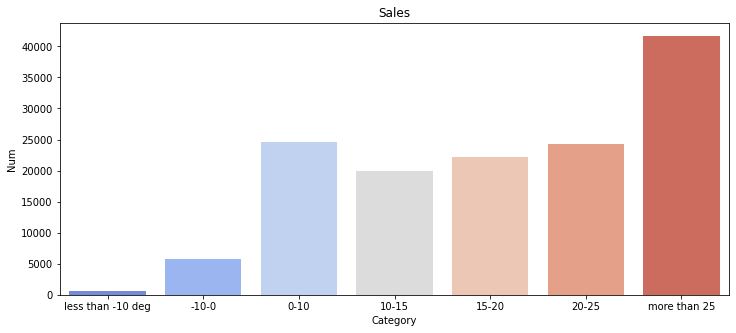

In [38]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="temperature_category", data=df1, palette="coolwarm")
ax.set(xlabel="Category", ylabel = "Num", title="Sales")
vals = ax.get_yticks()

##### Feature correletion analysis for store 1

In [39]:
df_store1=df1.where( df1['Store'] == 1)
df_store1=df_store1.groupby(by=['Date'], as_index=False)[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                                                  'IsHoliday_y', 'Weekly_Sales']].mean()
df_store1 = df_store1.set_index('Date')
df_store1.head()

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Weekly_Sales
Date,,,,,,
2010-02-05,5.727778,2.572,211.096358,8.106,0.0,22516.313699
2010-02-12,3.616667,2.548,211.242170,8.106,1.0,22804.964444
2010-02-19,4.405556,2.514,211.289143,8.106,0.0,22081.755753
2010-02-26,8.127778,2.561,211.319643,8.106,0.0,19579.549861
2010-03-05,8.055556,2.625,211.350143,8.106,0.0,21298.721644


In [40]:
cor_store1=df_store1.corr()
cor_store1

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Weekly_Sales
Temperature,1.000000,0.228493,0.118503,-0.180695,-0.200543,-0.166880
Fuel_Price,0.228493,1.000000,0.755259,-0.513944,-0.085903,0.149689
CPI,0.118503,0.755259,1.000000,-0.813471,-0.028919,0.234940
Unemployment,-0.180695,-0.513944,-0.813471,1.000000,0.082949,-0.116013
IsHoliday_y,-0.200543,-0.085903,-0.028919,0.082949,1.000000,0.172309
Weekly_Sales,-0.166880,0.149689,0.234940,-0.116013,0.172309,1.000000


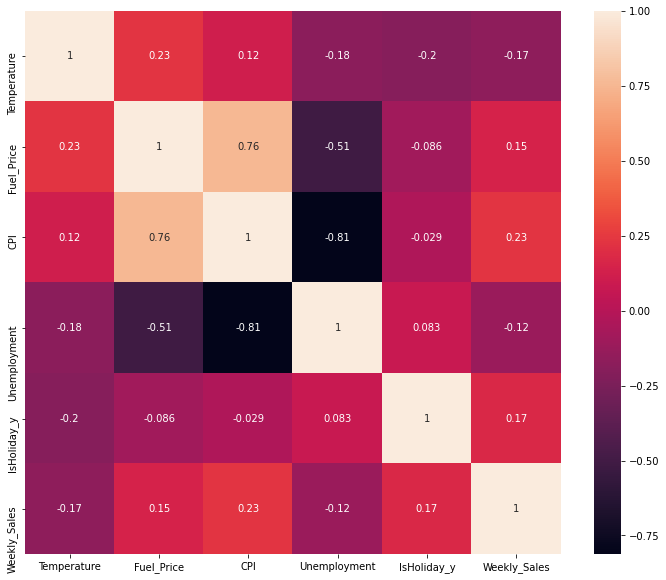

In [41]:
plt.figure(figsize=(12,10))
sns.heatmap(cor_store1, annot=True)
plt.show()

#### Forecasting

In [42]:
import sklearn
from sklearn.model_selection import train_test_split
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import fbprophet
from fbprophet import Prophet

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import performance_metrics

from fbprophet.plot import add_changepoints_to_plot

In [43]:
import sys
from setuptools import setup

# make hidden imports explicit
from setuptools.command import bdist_egg, easy_install

In [44]:
#Data Preparation for Fbprophet

df_forecast=df1.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()

df_forecast = df_forecast.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})
df_forecast

,ds,y
0,2010-02-05,19910348.85
1,2010-02-12,19092737.75
2,2010-02-19,19057399.45
3,2010-02-26,17517283.12
4,2010-03-05,18466385.02
...,...,...
138,2012-09-28,16529236.08
139,2012-10-05,18235643.78
140,2012-10-12,17458561.02
141,2012-10-19,17201215.17


In [45]:
# define the model
model = Prophet()
# fit the model
model.fit(df_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
#Range of weeks for forecast
future_dates = pd.date_range("20121216","20141230", freq='W')

In [47]:
future_dates = [pd.to_datetime(i) for i in future_dates]

In [48]:
import datetime as dt
future = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in future_dates],  columns=['ds'])


          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  2.579118e+07  2.404753e+07  2.760127e+07
1 2012-12-23  2.539128e+07  2.369827e+07  2.723660e+07
2 2012-12-30  2.234597e+07  2.051320e+07  2.418714e+07
3 2013-01-06  1.815274e+07  1.626893e+07  1.997591e+07
4 2013-01-13  1.533366e+07  1.357588e+07  1.699646e+07


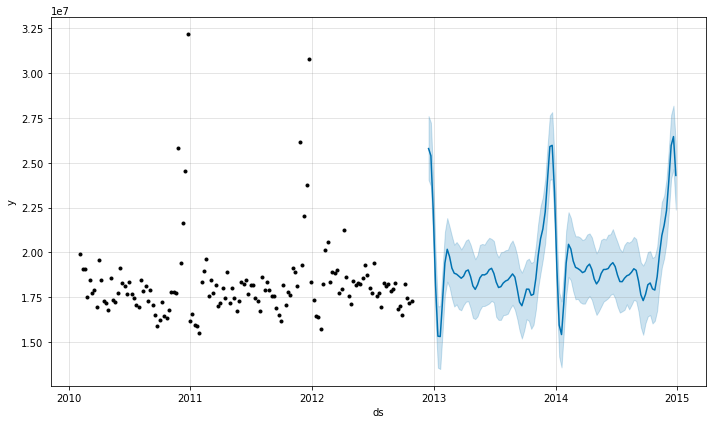

In [49]:
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [50]:
dates = pd.date_range("20111126","20121110", freq='W')
dates = [pd.to_datetime(i) for i in dates]
dates_for_forecast = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in dates],  columns=['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  2.579118e+07  2.404753e+07  2.760127e+07
1 2012-12-23  2.539128e+07  2.369827e+07  2.723660e+07
2 2012-12-30  2.234597e+07  2.051320e+07  2.418714e+07
3 2013-01-06  1.815274e+07  1.626893e+07  1.997591e+07
4 2013-01-13  1.533366e+07  1.357588e+07  1.699646e+07


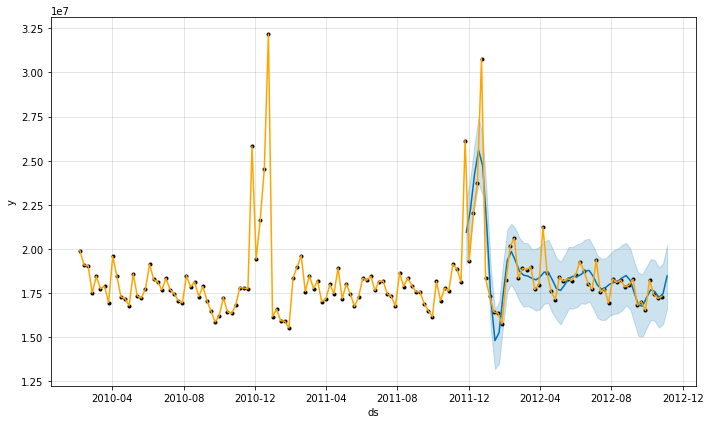

In [51]:
forecast_dates = model.predict(dates_for_forecast)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast_dates)
plt.plot(df_forecast.ds, df_forecast.y, color = 'orange')
plt.show()



Take CPI, Temperature, IsHoliday as regressors for our model


In [52]:
df_group_store1=df1.query('Store == 1')\
    .groupby(['Date', 'IsHoliday_y', 'CPI', 'Temperature'], as_index = False)\
    .agg({'Weekly_Sales':'sum'})
df_group_store1.head()

,Date,IsHoliday_y,CPI,Temperature,Weekly_Sales
0,2010-02-05,0,211.096358,5.727778,1643690.90
1,2010-02-12,1,211.242170,3.616667,1641957.44
2,2010-02-19,0,211.289143,4.405556,1611968.17
3,2010-02-26,0,211.319643,8.127778,1409727.59
4,2010-03-05,0,211.350143,8.055556,1554806.68


In [53]:
#Data Preparation for Fbprophet

df_group_store1 = df_group_store1.rename(columns = {'Date':'ds','Weekly_Sales':'y'})

datetime_series = pd.to_datetime(df_group_store1['ds'])

datetime_index = pd.DatetimeIndex(datetime_series.values)

Store1_data=df_group_store1.set_index(datetime_index)

Store1_data.head()

,ds,IsHoliday_y,CPI,Temperature,y
2010-02-05,2010-02-05,0,211.096358,5.727778,1643690.90
2010-02-12,2010-02-12,1,211.242170,3.616667,1641957.44
2010-02-19,2010-02-19,0,211.289143,4.405556,1611968.17
2010-02-26,2010-02-26,0,211.319643,8.127778,1409727.59
2010-03-05,2010-03-05,0,211.350143,8.055556,1554806.68


In [54]:
train_data_pr1 = Store1_data.iloc[:len(Store1_data)-40]
test_data_pr1 = Store1_data.iloc[len(Store1_data)-40:]
train_data_pr1.head()

,ds,IsHoliday_y,CPI,Temperature,y
2010-02-05,2010-02-05,0,211.096358,5.727778,1643690.90
2010-02-12,2010-02-12,1,211.242170,3.616667,1641957.44
2010-02-19,2010-02-19,0,211.289143,4.405556,1611968.17
2010-02-26,2010-02-26,0,211.319643,8.127778,1409727.59
2010-03-05,2010-03-05,0,211.350143,8.055556,1554806.68


In [55]:
test_data_pr1.head()

,ds,IsHoliday_y,CPI,Temperature,y
2012-01-27,2012-01-27,0,220.078852,12.366667,1319325.59
2012-02-03,2012-02-03,0,220.172015,13.638889,1636339.65
2012-02-10,2012-02-10,1,220.265178,8.900000,1802477.43
2012-02-17,2012-02-17,0,220.425759,7.400000,1819870.00
2012-02-24,2012-02-24,0,220.636902,14.027778,1539387.83


In [56]:
test_data_pr2 = test_data_pr1[['ds', 'IsHoliday_y', 'CPI', 'Temperature']]

In [57]:
# define the model
m1 = Prophet(changepoint_prior_scale=0.05, interval_width=0.95,\
             growth = 'linear',seasonality_mode = 'multiplicative', \
               yearly_seasonality=20, weekly_seasonality=True, changepoint_range=0.9)
m1.add_seasonality('weekly', period=7, fourier_order=15)

m1.add_regressor('IsHoliday_y')
m1.add_regressor('CPI')
m1.add_regressor('Temperature')
m1.fit(train_data_pr1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
35 2012-09-28  1.478004e+06  1.338901e+06  1.618903e+06
36 2012-10-05  1.584332e+06  1.446590e+06  1.711146e+06
37 2012-10-12  1.585909e+06  1.446955e+06  1.723031e+06
38 2012-10-19  1.480481e+06  1.350506e+06  1.610865e+06
39 2012-10-26  1.464123e+06  1.330499e+06  1.597968e+06


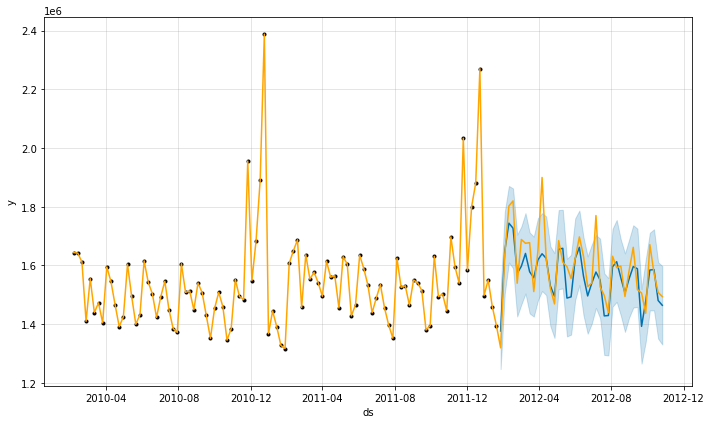

In [58]:
prophet_pred = m1.predict(test_data_pr2)


print(prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred)

plt.plot(Store1_data.ds, Store1_data.y, color = 'orange')

plt.show()

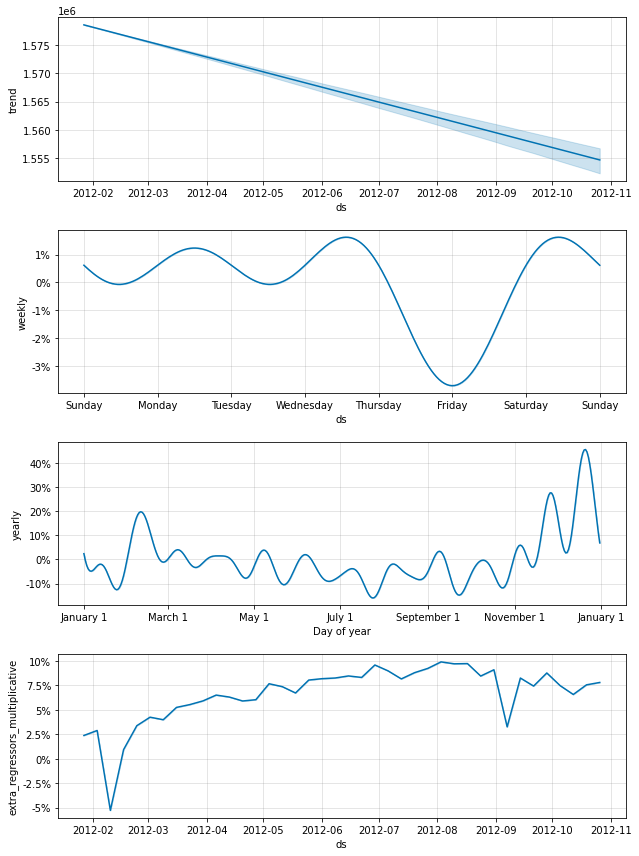

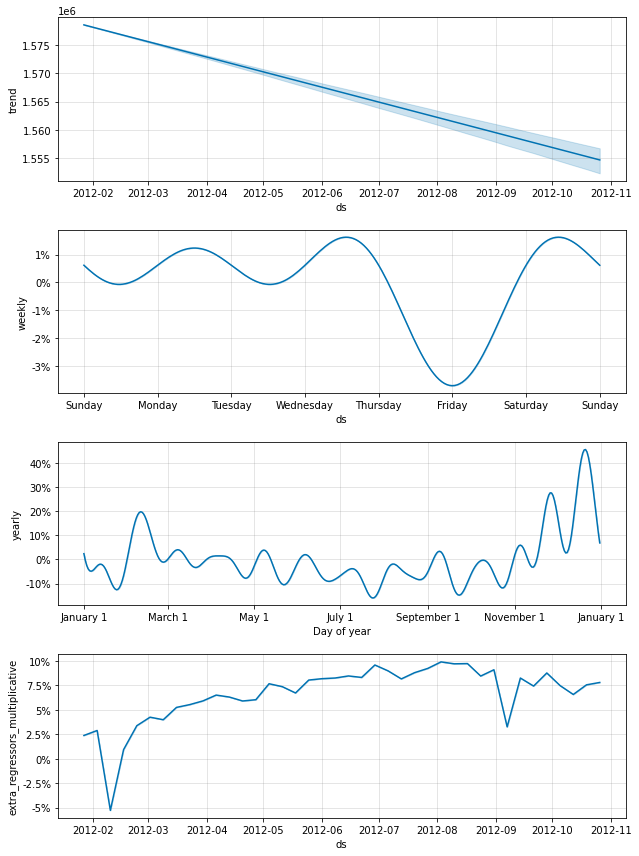

In [59]:
m1.plot_components(prophet_pred)

In [60]:
Store1_data_1 = Store1_data[['ds', 'IsHoliday_y', 'CPI', 'Temperature']]

            ds          yhat    yhat_lower    yhat_upper
138 2012-09-28  1.478004e+06  1.340750e+06  1.604690e+06
139 2012-10-05  1.584332e+06  1.453445e+06  1.715177e+06
140 2012-10-12  1.585909e+06  1.455293e+06  1.716855e+06
141 2012-10-19  1.480481e+06  1.344817e+06  1.599671e+06
142 2012-10-26  1.464123e+06  1.332105e+06  1.597474e+06


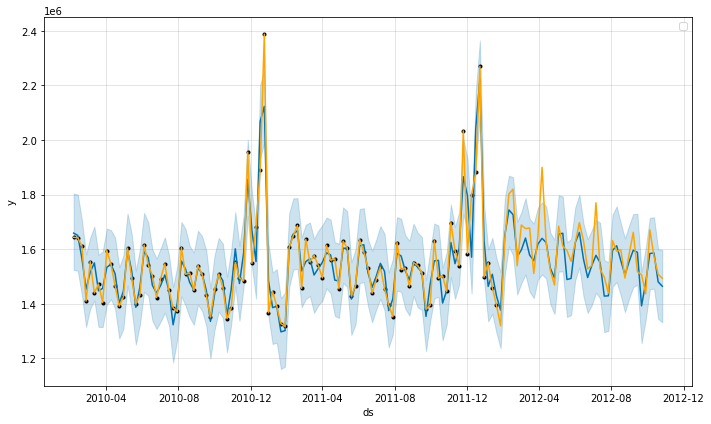

In [61]:
prophet_pred_1 = m1.predict(Store1_data_1)


print(prophet_pred_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred_1)


plt.plot(Store1_data.ds, Store1_data.y, color = 'orange')

for x in Store1_data[Store1_data['ds']=='2012-12-10']['ds']:
    plt.axvline(x=x, color='red', linewidth=0.5, ls='--', label='2012-12-10')
    

plt.legend()

plt.show()

In [62]:
prophet_pred_2 = prophet_pred_1[['ds','yhat']]
df_ds=pd.merge(Store1_data, prophet_pred_2, on=['ds'], how='left')
df_ds['diff'] = (df_ds['y']-df_ds['yhat'])/df_ds['y']

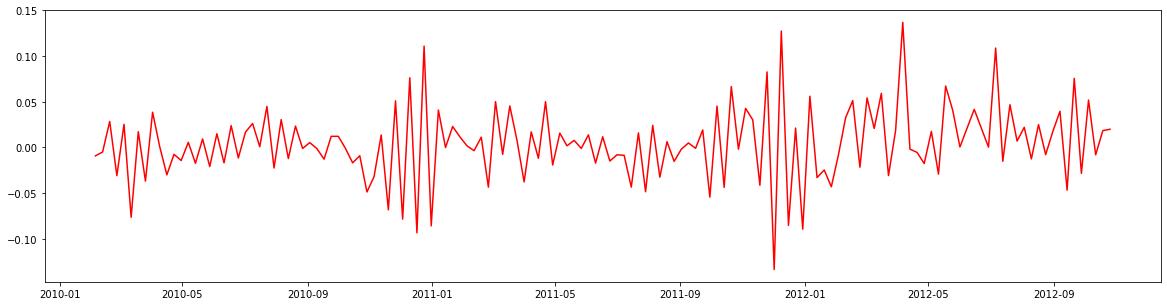

In [63]:
x1 = df_ds['ds']
y1 = df_ds['diff']
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x1.values, y1.values, c='r')

In [64]:
df_ds[['diff']].describe()

,diff
count,143.000000
mean,0.004045
std,0.041260
min,-0.133719
25%,-0.017027
50%,0.001650
75%,0.023502
max,0.136847


##### ARIMA forecast model

One of the common model used to forecast time series data is ARIMA. It stands for Autoregressive integrated moving average. One of the parameters are p, d & q. As you know the data has seasonality and let us use Seasonal ARIMA, SARIMAX to forecast the mode. There is a separate process to to identify the optmimum parameters, I did a grid search on GPU machine and it stopped after 700+ iterations.

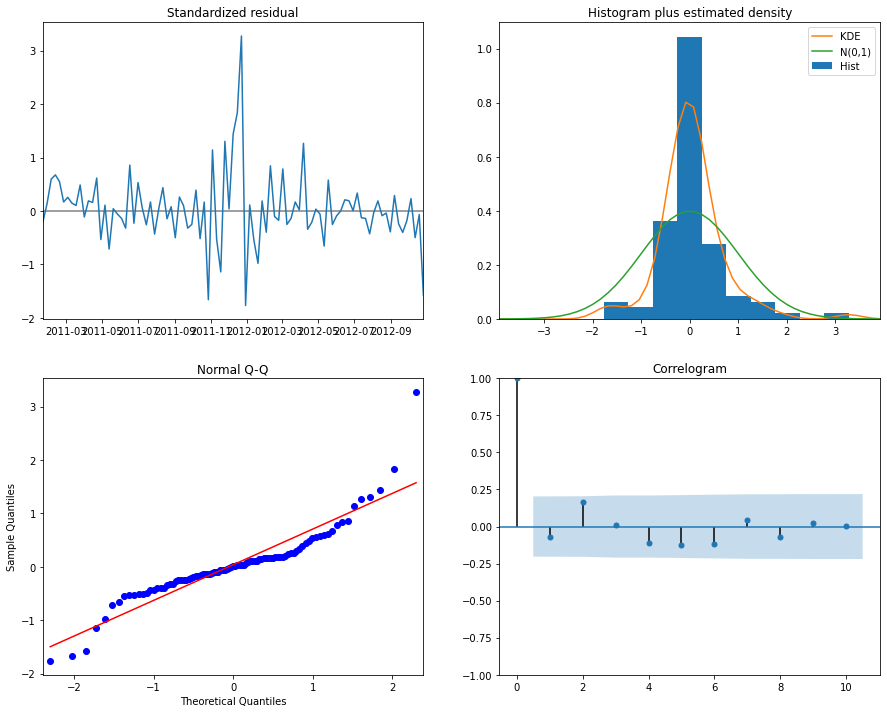

In [65]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

weekly_sales = df1.groupby('Date')['Weekly_Sales'].mean().dropna()
mod = sm.tsa.statespace.SARIMAX(weekly_sales,
                                    order = (2, 0, 4),
                                    seasonal_order = (3, 1, 2, 12),
                                    enforce_stationarity = False,
                                    enforce_invertibility = True)
results = mod.fit()
results.plot_diagnostics(figsize=(15,12))
plt.show()

##### Static patterns

As the expression suggests, the concept of a static pattern relates to the idea of something that does not change. 

In Time Series, the most famous proxy for this concept is [__stationarity__](https://en.wikipedia.org/wiki/Stationary_process), which refers to the statistical properties of a time series that remain static: the observations in a stationary time series are not dependent on time.



___Time series are stationary if they do not have trend or seasonal effects.___ 

The trend and seasonality will affect the value of the time series at different times. Traditionally, we would be looking for consistency over time, for example by using the mean or the variance of the observations. When a time series is stationary, it can be easier to model and statistical modeling methods usually assume or require the time series to be stationary to be effective. 



If you want to dig deeper into stationarity I recommend this [piece](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322#:~:text=In%20the%20most%20intuitive%20sense,not%20itself%20change%20over%20time.) by @Shay Palachy.

In [66]:
from statsmodels.tsa.stattools import adfuller

adf_test_sales = adfuller(list(df_store1["Weekly_Sales"]))
print("Retail sales results:")
print("ADF = " + str(adf_test_sales[0]))
print("p-value = " +str(adf_test_sales[1]))

Retail sales results:
ADF = -5.109955866900234
p-value = 1.3386969299359371e-05


#### Trends

A trend represents a tendency identified in our data. In a stock market scenario, this could be the trend of a given stock that appears to be going up or down. For Sales Forecasting, this is key: ___identifying a trend allows us to know the direction that our time-series is heading, which is fundamental for predicting the future of sales.___


We will use the [```fbprophet```](https://facebook.github.io/prophet/docs/quick_start.html) package to identify the overall trends for both our datasets. The steps will be:


- Select a range for the weather data (between 2007 and 2009)
- Feed the data to the ```fbprophet.Prophet``` object as a dataframe with two columns: "ds" (for date) and "y" (data) 

- Run the model
- Plot the trend with an upper and lower bound

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


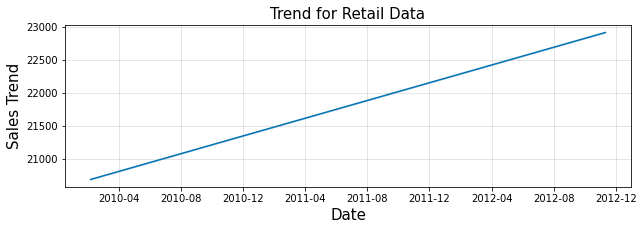

In [67]:
from fbprophet import Prophet


m = Prophet()
# Selecting one store
df_store_1=df_store1

df_store_1["Date"] = pd.to_datetime(df_store_1.index)
ds = df_store_1["Date"].dt.tz_localize(None)
y = df_store_1["Weekly_Sales"]
df_for_prophet = pd.DataFrame(dict(ds=ds,y=y))
m.fit(df_for_prophet)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)
forecast = forecast[["ds","trend", "trend_lower", "trend_upper"]]
fig = m.plot_components(forecast,plot_cap=False)
trend_ax = fig.axes[0]
trend_ax.plot()
plt.title("Trend for Retail Data", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Sales Trend", fontsize=15)

plt.show()

##### Traditional Time Series Models to Sales Forecasting




So far, we covered the basics of the sales forecasting problem and identified the main components of it from a time series perspective: repeating patterns, static patterns and the idea of a trend. If you want to dig deeper on time series, I recommend this [article](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a) by @Will Koehrsen.




Now we will look into the traditional time series approaches to deal with sales forecasting problems:




- Moving Average
- Exponential smoothing

- ARIMA

##### Moving Average
This model assumes that the next observation is the mean of all past observations and it can be used to identify interesting trends in the data. We can define a window to apply the moving average model to smooth the time series, and highlight different trends. 


Let's use the moving average model to predict the weather and sales. The steps will be:



- Select a range 
- Define a value for our moving average window
- Calculate the mean absolute error
- Plot an upper and lower bound for the rolling mean
- Plot the real data


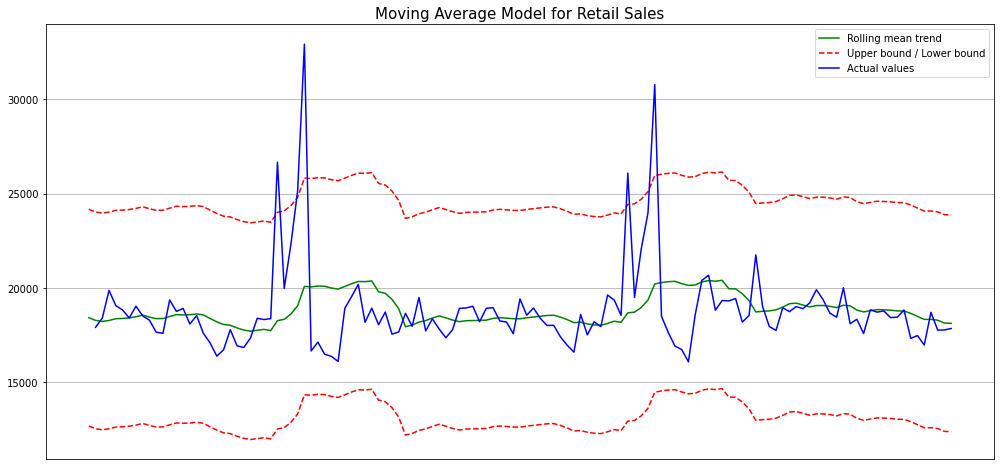

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

series = weekly_sales
window=15

rolling_mean = series.rolling(window=window).mean()
fig,ax = plt.subplots(figsize=(17,8))


plt.title('Moving Average Model for Retail Sales',fontsize=15)

plt.plot(rolling_mean, color= 'g', label='Rolling mean trend')

#Plot confidence intervals for smoothed values
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
lower_bound = rolling_mean - (mae + 1.92 * deviation)
upper_bound = rolling_mean + (mae + 1.92 * deviation)

plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
plt.plot(lower_bound, 'r--')

plt.plot(series[window:], color='b',label='Actual values')


plt.legend(loc='best')
plt.grid(True)
plt.xticks([])
plt.show()

##### Exponential Smoothing

Exponential smoothing is similar to moving average, but in this case a decreasing weight is assigned to each observation, so less importance is given to observations as we move further from the present. Such an assumption can be good and bad: it can be beneficial to decrease the weight of outdates information within the time-series dynamics, but it can be harmful when past information has some kind of permanent causal relationship with the dynamics of the data.  

Let's use exponential smoothing in the weather dataset used above, we will:
- Fit the data 
- Forecast 

- Plot the prediction agains the real values

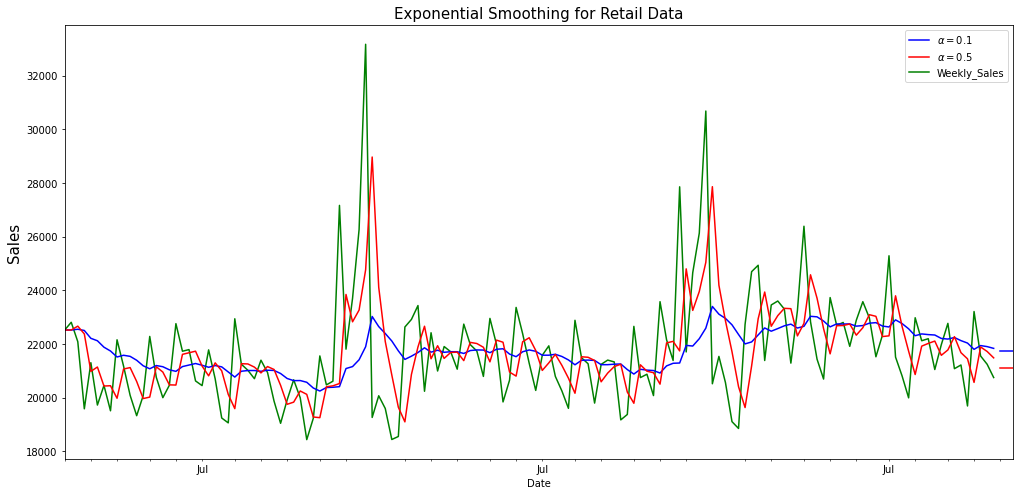

In [69]:
from statsmodels.tsa.api import ExponentialSmoothing
fit1 = ExponentialSmoothing(df_store1["Weekly_Sales"][0:200]).fit(smoothing_level=0.1, optimized=False)

fit2 = ExponentialSmoothing(df_store1["Weekly_Sales"][0:200]).fit(smoothing_level=0.5, optimized=False)

forecast1 = fit1.forecast(3).rename(r'$\alpha=0.1$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.5$')
plt.figure(figsize=(17,8))

forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
df_store1["Weekly_Sales"][0:200].plot(marker='',color='green', legend=True)
plt.ylabel("Sales", fontsize=15)

fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')

plt.title("Exponential Smoothing for Retail Data", fontsize=15)
plt.xticks([], minor=True)
plt.show()

##### Arima
ARIMA or Auto-regressive Integrated Moving Average is a time series model that aims to describe the auto-correlations in the time series data. It works well for short-term predictions and it can be useful to provide forecasted values for user-specified periods showing good results for demand, sales, planning, and production.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model
- d: The number of times that the raw observations are differenced
- q: The size of the moving average window

Now I am going to use ARIMA model to model the weather data and retail sales. The steps will be:
- Split the data into training and testing
- Fit the data
- Print the mean square error (our evaluation metric)
- Plot the model fit with the real values


predicted=21086.653738, expected=27853.707671
predicted=25991.373863, expected=21699.780137
predicted=21788.680558, expected=24653.183288
predicted=23852.231190, expected=26127.453750
predicted=26200.703491, expected=30678.229595
predicted=25531.770648, expected=20513.187945
predicted=25271.559979, expected=21532.915556
predicted=23787.405310, expected=20557.762958
predicted=24260.793903, expected=19101.285479
predicted=18087.587985, expected=18847.508429
predicted=21708.914009, expected=22726.939583
predicted=21027.694722, expected=24691.471644
predicted=22502.684710, expected=24929.726027
predicted=23403.951437, expected=21380.386528
predicted=22604.100775, expected=23450.288333
predicted=23055.221014, expected=23597.621972
predicted=23394.812515, expected=23298.233056
predicted=22562.528300, expected=21282.648873
predicted=23174.815542, expected=23233.868028
predicted=22767.508135, expected=26384.401111
predicted=24770.546441, expected=22831.432394
predicted=22667.077680, expected=2

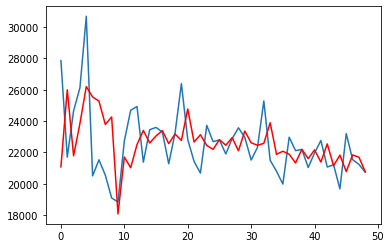

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  141
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1274.772
Method:                       css-mle   S.D. of innovations           2036.030
Date:                Wed, 21 Apr 2021   AIC                           2563.544
Time:                        03:31:23   BIC                           2584.185
Sample:                             1   HQIC                          2571.932
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6005     74.289     -0.048      0.961    -149.204     142.003
ar.L1.D.y     -0.4856      0.083     -5.856      0.000      -0.648      -0.323
ar.L2.D.y     -0.4113      0.092     -4.462      0.0

In [70]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot

X = df_store1["Weekly_Sales"].values

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
print(model_fit.summary())